# Sentiment Analysis

### **Objective:**
To develop a robust binary classification model capable of accurately discerning whether a customer review expresses a positive or negative sentiment.  

### **Data:**
The dataset was created for the paper 'From Group to Individual Labels using Deep Features' by Kotzias et al., presented at KDD 2015. It consists of sentences labeled with positive (scored as 1) or negative (scored as 0) sentiment. The data is sourced from three different websites/fields: imdb.com, amazon.com, and yelp.com. Each website contributes 500 positive and 500 negative sentences, randomly selected from larger review datasets. The aim was to choose sentences with a clear positive or negative connotation, avoiding neutral sentences. Researchers are encouraged to cite the paper if they use this dataset.

### **Problem Statement:**
Identifying the emotion behind human text is an important part of NLP for various applications including customer review analysis and artificial intelligence.

### **1) Libraries**

In [1]:
import warnings

# Deactivate all warnings
warnings.filterwarnings("ignore")

In [69]:
# Libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from autocorrect import Speller

from string import punctuation
import re
from emoji import demojize
import neattext.functions as nfx

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, Embedding, SpatialDropout1D, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Nadam
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import train_test_split


import emoji
import neattext.functions as nfx
import contractions
import string
import inflect

import os


In [72]:
nltk.download('wordnet')

stop_words= []

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jocmi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [73]:
stop_words

[]

### **2) Importing data sets**

In [74]:
path = "C:/data_bases/jquinatoa_sentiment_labelled_sentences/sentiment labelled sentences/datasets/"

data_set = pd.DataFrame()
for dataset in os.listdir(path):
    temp_data_set = pd.read_csv(str(path+dataset), delimiter='\t',header=None, names=['text', 'label'])
    data_set = pd.concat([temp_data_set,data_set])

In [75]:
def explore_data_set(data_set):
    print('--> Head Data Set:')
    print(data_set.head(5))
    print("--> Data Set Information")
    print(data_set.info())
    print("--> Data Set Description")
    print(data_set.describe())

In [76]:
data_set = data_set.sample(frac=1, random_state=23).reset_index(drop=True)
data_set['label'].replace({0: 'negative', 1: 'positive'}, inplace=True)
explore_data_set(data_set)

--> Head Data Set:
                                                text     label
0  There is simply no excuse for something this p...  negative
1  !....THE OWNERS REALLY REALLY need to quit bei...  negative
2  Their regular toasted bread was equally satisf...  positive
3  From what my dinner companions told me...every...  positive
4  I love being able to use one headset for both ...  positive
--> Data Set Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2748 non-null   object
 1   label   2748 non-null   object
dtypes: object(2)
memory usage: 43.1+ KB
None
--> Data Set Description
                      text     label
count                 2748      2748
unique                2731         2
top     Not recommended.    positive
freq                     2      1386


In [77]:
X, X_test, y, y_test = train_test_split(data_set['text'], data_set['label'], test_size=400, random_state=23)

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=800, random_state=23)

### **3) Data cleaning**

In [78]:
class Data_Cleaning():
    def __init__ (self, data_frame, subset):
        self.dataframe = data_frame
        self.subset = subset
        
    def remove_duplicates (self):
        df = self.dataframe
        count = df[self.subset].duplicated(keep=False).sum()
        print(f"--> {count} duplicated values were found and dropped")
        df = df.drop_duplicates(subset=self.subset, keep=False)
        return df
    
    def remove_na (self):
        df = self.dataframe
        count = df[self.subset].isna().sum()
        print(f"--> {count} na values were found and dropped")
        df = df.dropna(subset = self.subset)
        return df
        
def data_cleaning_pipeline(DataFrame, subset):
    DataFrame = Data_Cleaning(DataFrame,subset).remove_duplicates()
    DataFrame = Data_Cleaning(DataFrame,subset).remove_na()
    return DataFrame

In [79]:
training_data = data_cleaning_pipeline(pd.concat([X_train, y_train], axis=1),'text')
validation_data = data_cleaning_pipeline(pd.concat([X_validation, y_validation], axis=1),'text')
testing_data = data_cleaning_pipeline(pd.concat([X_test, y_test], axis=1),'text')

--> 12 duplicated values were found and dropped
--> 0 na values were found and dropped
--> 2 duplicated values were found and dropped
--> 0 na values were found and dropped
--> 2 duplicated values were found and dropped
--> 0 na values were found and dropped


In [80]:
class Text_Cleaning():
    def __init__ (self, txt):
        self.txt = txt.lower()
    
    def expand_contractions(self):
        txt = self.txt
        txt = contractions.fix(txt)
        return txt
    
    def replace_numbers_with_words(self):
        p = inflect.engine()

        def replace(match):
            number = int(match.group())
            return p.number_to_words(number)

        # Use regular expression to find numeric substrings
        pattern = re.compile(r'\b\d+\b')
        result = pattern.sub(replace, self.txt)

        return result
    
    def remove_stopword(self):
        txt = self.txt
        txt = " ".join([word for word in str(txt).split() if word not in stop_words])
        return txt
        
    def transform_emojis(self):
        txt = self.txt
        txt = ''.join(emoji.demojize(char) for char in txt)
        expressions = [
            r'_', 
            r':' 
        ]
        
        def temp_funct(text):
            for expression in expressions:
                    text = re.sub(expression, ' ', text)
            return text
        
        txt = [temp_funct(_) for _ in txt.split()]
        txt = " ".join(txt)
        return txt
    
    def remove_users(self):
        txt = nfx.remove_userhandles(self.txt)
        return txt
    
    def remove_punctuation(self):
        txt = self.txt
        punc_list = string.punctuation
        def temp_funct(text):
            for expression in punc_list:
                    text = re.sub(re.escape(expression), ' ', text)
            return text
        
        txt = [temp_funct(_) for _ in self.txt.split()]
        txt = " ".join(txt)
        
        punc_list = list(set(punctuation))
        txt = " ".join(["".join([letter for letter in word if letter not in punc_list]) for word in str(txt).split()])
               
        return txt
    
    def text_cleaner(self):
        txt = nfx.clean_text( text= self.txt,
                                puncts= True,
                                stopwords= False,
                                urls= True,
                                emails= True,
                                numbers= False,
                                emojis= True,
                                special_char= True,
                                phone_num= True,
                                non_ascii= True,
                                multiple_whitespaces= True,
                                contractions= True,
                                currency_symbols= True,
                                custom_pattern= None)
        return txt
        
    def lemmatization(self):
        lemmatizer = nltk.stem.WordNetLemmatizer()
        wordnet_map={"N":nltk.corpus.wordnet.NOUN, "V":nltk.corpus.wordnet.VERB, "J":nltk.corpus.wordnet.ADJ, "R":nltk.corpus.wordnet.ADV}
        pos_tag = nltk.pos_tag(self.txt.split())
        txt = " ".join([lemmatizer.lemmatize(word , wordnet_map.get(pos[0], nltk.corpus.wordnet.NOUN)) for word, pos in pos_tag])
        return txt
    

def text_cleaning_pipeline(DataFrame, text_column):
    df = DataFrame
    df[f'preprocessed_{text_column}'] = df[text_column].apply(lambda x: Text_Cleaning(x).expand_contractions())
    df[f'preprocessed_{text_column}'] = df[f'preprocessed_{text_column}'].apply(lambda x: Text_Cleaning(x).replace_numbers_with_words())
    df[f'preprocessed_{text_column}'] = df[f'preprocessed_{text_column}'].apply(lambda x: Text_Cleaning(x).remove_stopword())
    df[f'preprocessed_{text_column}'] = df[f'preprocessed_{text_column}'].apply(lambda x: Text_Cleaning(x).remove_users())
    df[f'preprocessed_{text_column}'] = df[f'preprocessed_{text_column}'].apply(lambda x: Text_Cleaning(x).transform_emojis())
    df[f'preprocessed_{text_column}'] = df[f'preprocessed_{text_column}'].apply(lambda x: Text_Cleaning(x).remove_punctuation())
    df[f'preprocessed_{text_column}'] = df[f'preprocessed_{text_column}'].apply(lambda x: Text_Cleaning(x).text_cleaner())
    df[f'preprocessed_{text_column}'] = df[f'preprocessed_{text_column}'].apply(lambda x: Text_Cleaning(x).lemmatization())
    
    df= df[df[f'preprocessed_{text_column}']!='']
        
    return df

In [81]:
training_data = text_cleaning_pipeline(training_data,'text')
validation_data = text_cleaning_pipeline(validation_data,'text')
testing_data = text_cleaning_pipeline(testing_data,'text')

In [82]:
# Extracting labels from training, validation, and testing data
train_data_labels = training_data['label']
validation_data_labels = validation_data['label']
testing_data_labels = testing_data['label']

# Creating a label encoder and fitting it to the training labels
label_encoder = LabelEncoder().fit(training_data['label']) 

# Transforming labels to numerical codes
train_data_labels = label_encoder.transform(train_data_labels)
validation_data_labels = label_encoder.transform(validation_data_labels)
testing_data_labels = label_encoder.transform(testing_data_labels)

# Mapping numerical codes back to original labels for reference
keys = np.unique(validation_data_labels)
values = label_encoder.inverse_transform(keys)

# Creating a dictionary to display the mapping between labels and codes
data = {key: value for key, value in zip(keys, values)}
print("--> Labels and Codes")
print(data)

--> Labels and Codes
{0: 'negative', 1: 'positive'}


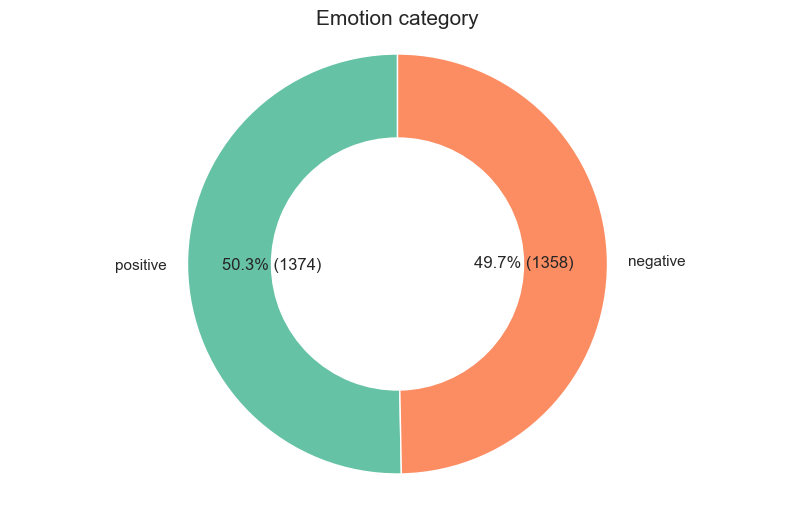

In [83]:

# Concatenate the label columns from the dataframes
all_labels = pd.concat([training_data['label'], validation_data['label'], testing_data['label']])

# Set the figure size and style
plt.figure(figsize=(10, 6))
plt.title('Emotion category', fontsize=15)
sns.set(style="darkgrid")

# Convert the 'label' column to a categorical data type
all_labels = all_labels.astype('category')

# Create a DataFrame with the categorical data
data_to_plot = pd.DataFrame({'Emotion': all_labels})

# Count the occurrences of labels
label_counts = data_to_plot['Emotion'].value_counts()

# Plot the pie chart
pie_chart = label_counts.plot.pie(autopct=lambda p: '{:.1f}% ({:.0f})'.format(p, p * sum(label_counts) / 100),
                                  startangle=90, colors=sns.color_palette('Set2'), wedgeprops=dict(width=0.4))

# Optionally, you can set the aspect ratio to make the pie chart a circle
plt.axis('equal')

# Show the plot
plt.ylabel(None)
plt.show()

In [84]:
# Extracting text data from different sets
training_data_text = training_data['preprocessed_text']
validation_data_text = validation_data['preprocessed_text']
testing_data_text = testing_data['preprocessed_text']

In [85]:
def df_converter(data_text):
    temp = pd.DataFrame(data_text, columns=['text', 'preprocessed_text', 'label'])
    temp = temp.sample(frac=1, random_state=23)
    temp.reset_index(inplace=True, drop=True)
    return temp

In [86]:
# Convert to dataframe
print('--> training preprocessed text')
temp_training = df_converter(training_data)
display(temp_training.head(10).style)
print(f'{len(temp_training)} comments\n')

print('--> validation preprocessed text')
temp_validation = df_converter(validation_data)
display(temp_validation.head(10).style)
print(f'{len(temp_validation)} comments\n')

print('--> testing preprocessed text')
temp_testing = df_converter(testing_data)
display(temp_testing.head(10).style)
print(f'{len(temp_testing)} comments\n')

--> training preprocessed text


,text,preprocessed_text,label
0,We've tried to like this place but after 10+ times I think we're done with them.,we have try to like this place but after ten time i think we be do with them,negative
1,"If you want healthy authentic or ethic food, try this place.",if you want healthy authentic or ethic food try this place,positive
2,"It took over 30 min to get their milkshake, which was nothing more than chocolate milk.",it take over thirty min to get their milkshake which be nothing more than chocolate milk,negative
3,The jalapeno bacon is soooo good.,the jalapeno bacon be soooo good,positive
4,We waited for thirty minutes to be seated (although there were 8 vacant tables and we were the only folks waiting).,we wait for thirty minute to be seat although there be eight vacant table and we be the only folk wait,negative
5,Best of luck to the rude and non-customer service focused new management.,best of luck to the rude and non customer service focus new management,negative
6,This is an extraordinary film.,this be an extraordinary film,positive
7,"Point your finger at any item on the menu, order it and you won't be disappointed.",point your finger at any item on the menu order it and you will not be disappoint,positive
8,No real improvement.,no real improvement,negative
9,It's one of the movies I need to see whenever it comes on TV...never mind the fact that I already have it memorized!,it be one of the movie i need to see whenever it come on tv never mind the fact that i already have it memorize,positive


1536 comments

--> validation preprocessed text


,text,preprocessed_text,label
0,I was able to do voice dialing in the car with no problem.,i be able to do voice dial in the car with no problem,positive
1,"You can't relate with them, hell you barely can understand them.",you cannot relate with them hell you barely can understand them,negative
2,The movie had you on the edge of your seat and made you somewhat afraid to go to your car at the end of the night.,the movie have you on the edge of your seat and make you somewhat afraid to go to your car at the end of the night,positive
3,"It was either too cold, not enough flavor or just bad.",it be either too cold not enough flavor or just bad,negative
4,Worst Customer Service Ever.,worst customer service ever,negative
5,"He really didn't seem to want to be hosting; his voice-overs were monotonous, didn't get involved with the guests.",he really do not seem to want to be host his voice over be monotonous do not get involve with the guest,negative
6,I thought Errol Flynn was brilliant as Custer and has since become my favourite actor!,i think errol flynn be brilliant a custer and have since become my favourite actor,positive
7,"This was utterly confusing at first, which caused me to lose a couple of very, very important contacts.",this be utterly confusing at first which cause me to lose a couple of very very important contact,negative
8,The classic Maine Lobster Roll was fantastic.,the classic maine lobster roll be fantastic,positive
9,The things that the four kids get themselves into is absolutely hilarious to watch.,the thing that the four kid get themselves into be absolutely hilarious to watch,positive


798 comments

--> testing preprocessed text


,text,preprocessed_text,label
0,Great Hands Free Device.,great hand free device,positive
1,There's also enough hypocrisy in this film to make me vomit.,there be also enough hypocrisy in this film to make me vomit,negative
2,I give Wirefly 1 star.I will contact Cingular/AT&T; and inform them of this practice.,i give wirefly one star i will contact cingular at t and inform them of this practice,negative
3,This product is ideal for people like me whose ears are very sensitive.,this product be ideal for people like me whose ear be very sensitive,positive
4,"first of all, there are enough racial stereotypes and racial jokes to offend everyone.",first of all there be enough racial stereotype and racial joke to offend everyone,negative
5,NOBODY identifies with these characters because they're all cardboard cutouts and stereotypes (or predictably reverse-stereotypes).,nobody identifies with these character because they be all cardboard cutout and stereotype or predictably reverse stereotype,negative
6,Not a single employee came out to see if we were OK or even needed a water refill once they finally served us our food.,not a single employee come out to see if we be ok or even need a water refill once they finally serve u our food,negative
7,Car charger as well as AC charger are included to make sure you never run out of juice.Highy recommended,car charger as well a ac charger be include to make sure you never run out of juice highy recommend,positive
8,It was a great phone.,it be a great phone,positive
9,"however, my girl was complain that some time the phone doesn't wake up like normal phone does.",however my girl be complain that some time the phone do not wake up like normal phone do,negative


398 comments



In [87]:
class TokenPadding():
    def __init__(self, train_data_text, vocab_size):
        self.train_data_text = train_data_text
        self.vocab_size = vocab_size
        
    def max_row_length(self):
        dataframe = self.train_data_text
        dataframe = pd.DataFrame(dataframe)
        dataframe['text_length'] = dataframe['preprocessed_text'].apply(lambda x: x.count(' ')+1)
        max_length = dataframe['text_length'].quantile(0.9)
        return int(max_length)
    
    def tokenizer (self):
        tokenizer = Tokenizer(num_words = self.vocab_size)
        tokenizer.fit_on_texts(self.train_data_text)
        return tokenizer 
    
    def token_generator (self, data_text):
        max_len = self.max_row_length()
        tokenizer = self.tokenizer()
        
        # Tokenize and pad sequences for train data
        data_text = data_text.apply(lambda text:  tokenizer.texts_to_sequences([text])[0])
        data_text = np.array(data_text)
        data_text = pad_sequences(data_text, maxlen=max_len)
        
        return data_text

In [88]:
# Set the vocabulary size 
vocab_size = 1500

# Create an instance of the TokenPadding c
token_padding_instance = TokenPadding(training_data_text, vocab_size=vocab_size)

max_len = token_padding_instance.max_row_length()

In [89]:
# Generate tokenized sequences for training, validation, and testing
X_train = token_padding_instance.token_generator(training_data_text)
X_validation = token_padding_instance.token_generator(validation_data_text)
X_testing = token_padding_instance.token_generator(testing_data_text)

In [90]:
# Generate tokenized sequences for training, validation, and testing
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 1)
X_testing = X_testing.reshape(X_testing.shape[0], X_testing.shape[1], 1)

In [91]:
print(X_train.shape, train_data_labels.shape)
print(X_validation.shape, validation_data_labels.shape)
print(X_testing.shape, testing_data_labels.shape)

(1536, 23, 1) (1536,)
(798, 23, 1) (798,)
(398, 23, 1) (398,)


### **2) Modeling**

* ##### Experiment #1 GRU

In [92]:
# Create a model using Sequential()
model_gru = Sequential()
# Add an Embedding layer 
model_gru.add(Embedding(vocab_size, output_dim=80, input_length= max_len))
# Add Spatial Dropout to prevent overfitting
model_gru.add(SpatialDropout1D(0.1))
# Add a GRU layer
model_gru.add(GRU(80, reset_after=False))
# Add Spatial Dropout to prevent overfitting
model_gru.add(Dropout(0.1))
# Change the number of units in the output layer to the number of classes
model_gru.add(Dense(1, activation='sigmoid'))

# Change the loss function to 'categorical_crossentropy'
model_gru.compile(loss='binary_crossentropy', optimizer=Nadam(learning_rate=0.0001), metrics=['accuracy'])

model_gru.summary()

# Define callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= 'models/gru_model.h5',
                                                         save_best_only=True,
                                                         monitor='accuracy',
                                                         mode='max',
                                                         verbose=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=3,
                                                          restore_best_weights=True,
                                                          verbose=1)

history_gru_m = model_gru.fit(X_train, 
                            train_data_labels,
                            batch_size= 1,
                            validation_data=(X_validation, validation_data_labels), 
                            epochs = 100,
                            callbacks=[checkpoint_callback, early_stopping_callback])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 23, 80)            120000    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 23, 80)           0         
 lDropout1D)                                                     
                                                                 
 gru_1 (GRU)                 (None, 80)                38640     
                                                                 
 dropout_2 (Dropout)         (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 81        
                                                                 
Total params: 158,721
Trainable params: 158,721
Non-trainable params: 0
________________________________________________

* ##### Experiment #2 Bidirectional LSTM

In [98]:
# Create a model using Sequential()
model_bilstm = Sequential()
# Add an Embedding layer 
model_bilstm.add(Embedding(vocab_size, output_dim= 100, input_length= max_len))
# Add Spatial Dropout to prevent overfitting
model_bilstm.add(SpatialDropout1D(0.2))
# Add a Bidirectional LSTM layer
model_bilstm.add(Bidirectional(LSTM(100)))
# Add Spatial Dropout to prevent overfitting
model_bilstm.add(Dropout(0.2))

# Change the number of units in the output layer to the number of classes
model_bilstm.add(Dense(1, activation='sigmoid'))

# Change the loss function to 'categorical_crossentropy'
model_bilstm.compile(loss='binary_crossentropy', optimizer=Nadam(learning_rate=0.0001), metrics=['accuracy'])

model_bilstm.summary()

# Define callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='models/bilstm_model.h5.h5',
                                                         save_best_only=True,
                                                         monitor='accuracy',
                                                         mode='max',
                                                         verbose=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=3,
                                                          restore_best_weights=True,
                                                          verbose=1)

history_bilstm_m = model_bilstm.fit(X_train, 
                            train_data_labels,
                            batch_size= 1,
                            validation_data=(X_validation, validation_data_labels), 
                            epochs = 100,
                            callbacks=[checkpoint_callback, early_stopping_callback])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 23, 100)           150000    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 23, 100)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 201       
                                                                 
Total params: 311,001
Trainable params: 311,001
Non-tr

### **3) Models Performance**

In [99]:
def visual_analysis(model, data_text, data_labels, data_set, threshold = 0.5):
    # Convert predictions to binary labels (0 or 1)
    predicted_labels = model.predict(data_text, verbose=0).flatten()
    predicted_labels_binary = [1 if label > threshold else 0 for label in predicted_labels]
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(data_labels, predicted_labels_binary)
        
    labels = ['negative', 'positive']
    
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(20, 5))

    # Subplot 1: Confusion Matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title(f'Confusion Matrix - {data_set} Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Subplot 2: ROC Curve
    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(data_labels, predicted_labels)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Subplot 3: Precision-Recall Curve
    plt.subplot(1, 3, 3)
    precision, recall, _ = precision_recall_curve(data_labels, predicted_labels)
    average_precision = average_precision_score(data_labels, predicted_labels)
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precission & Recall curve (AUC = {average_precision:.2f})')
    plt.plot([1, 0], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precission')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
def predictions(model, data_text, threshold):
    # Convert predictions to binary labels (0 or 1)
    predicted_labels = model.predict(data_text, verbose=0).flatten()
    predicted_labels_binary = [1 if label > threshold else 0 for label in predicted_labels]
    return predicted_labels_binary

* ##### Experiment #1 GRU

--> Model Train Accuracy: 0.8990885416666666
--> Model Validation Accuracy: 0.7857142857142857
--> Model Classification Report: 
              precision    recall  f1-score   support

    negative       0.81      0.72      0.76       380
    positive       0.77      0.84      0.80       418

    accuracy                           0.79       798
   macro avg       0.79      0.78      0.78       798
weighted avg       0.79      0.79      0.78       798

--> Visual Analysis


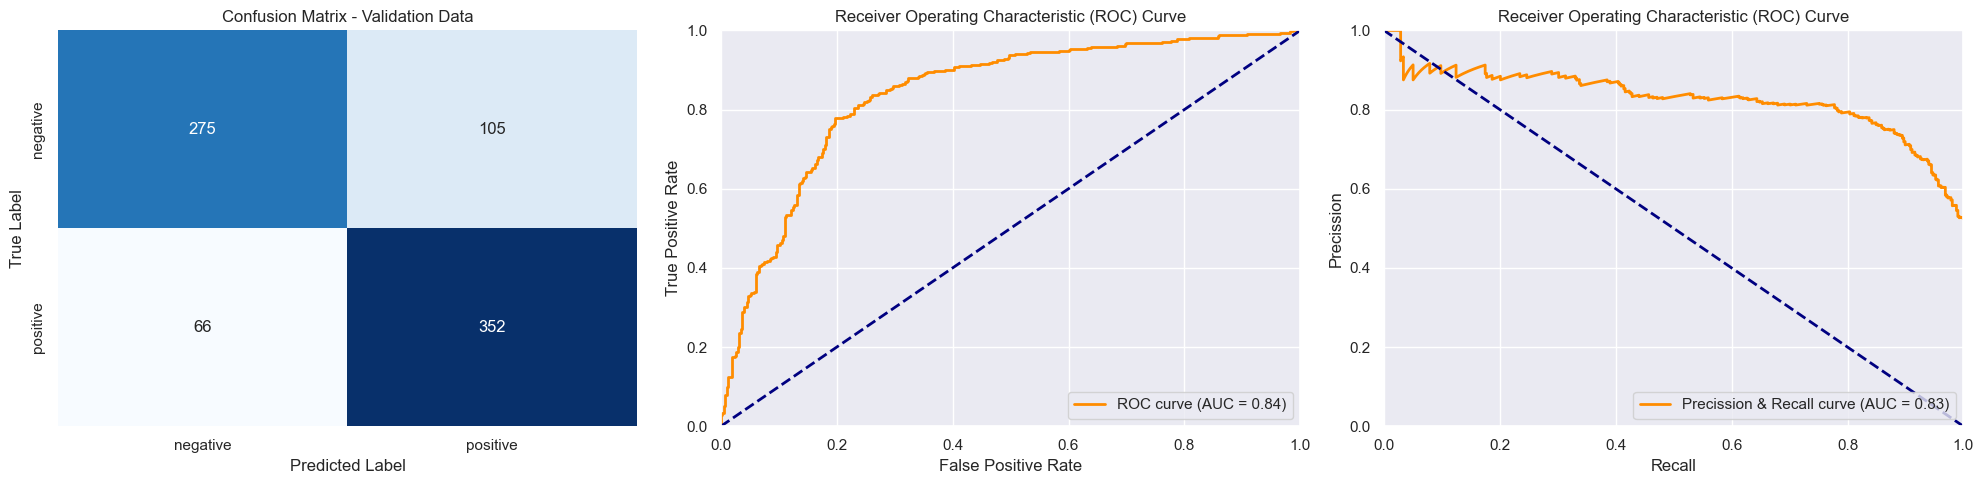

In [100]:
# Calculate accuracy
accuracy = accuracy_score(train_data_labels, predictions(model_gru, X_train, 0.44))
print(f"--> Model Train Accuracy: {accuracy}")
accuracy = accuracy_score(validation_data_labels, predictions(model_gru, X_validation, 0.44))
print(f"--> Model Validation Accuracy: {accuracy}")
class_report = classification_report(validation_data_labels, predictions(model_gru, X_validation, 0.44), target_names=['negative', 'positive'])
print(f"--> Model Classification Report: \n{class_report}")

print('--> Visual Analysis')
visual_analysis(model_gru, X_validation, validation_data_labels, 'Validation', 0.44)

* ##### Experiment #2 Bidirectional LSTM

--> Model Train Accuracy: 0.9049479166666666
--> Model Validation Accuracy: 0.7969924812030075
--> Model Classification Report: 
              precision    recall  f1-score   support

    negative       0.83      0.72      0.77       380
    positive       0.77      0.87      0.82       418

    accuracy                           0.80       798
   macro avg       0.80      0.79      0.79       798
weighted avg       0.80      0.80      0.80       798

--> Visual Analysis


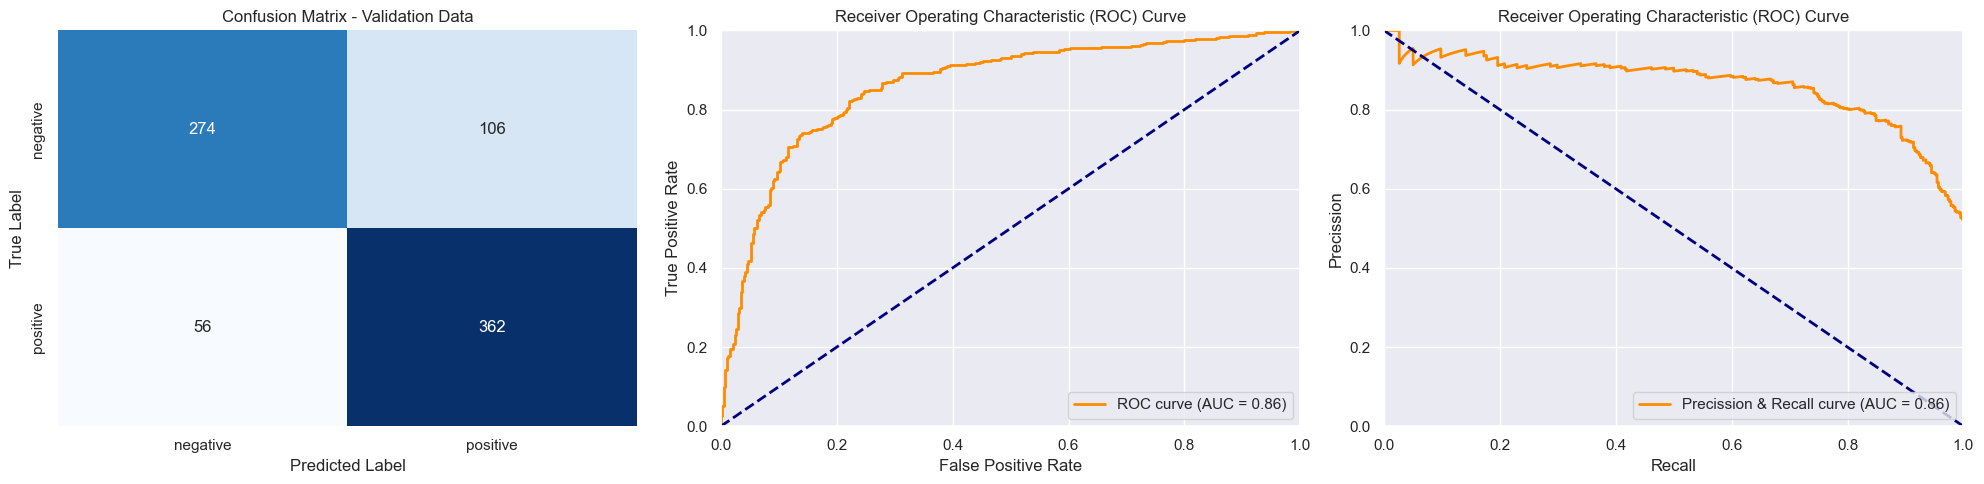

In [101]:
# Calculate accuracy
accuracy = accuracy_score(train_data_labels, predictions(model_bilstm, X_train, 0.28))
print(f"--> Model Train Accuracy: {accuracy}")
accuracy = accuracy_score(validation_data_labels, predictions(model_bilstm, X_validation, 0.28))
print(f"--> Model Validation Accuracy: {accuracy}")
class_report = classification_report(validation_data_labels, predictions(model_bilstm, X_validation, 0.28), target_names=['negative', 'positive'])
print(f"--> Model Classification Report: \n{class_report}")

print('--> Visual Analysis')
visual_analysis(model_bilstm, X_validation, validation_data_labels, 'Validation', 0.28)

### **4) Conclusion**

* The Bidirectional LSTM demonstrates strong training performance, but there is a slight dip in validation and testing performance, suggesting a potential issue with overfitting.

* In contrast, the Plain RNN Model exhibits the lowest overall performance across all datasets, indicating a possible limitation in capturing underlying data patterns.

* The LSTM displays high training performance, with a marginal decrease in validation and testing performance, akin to the Bidirectional LSTM.

* The GRU stands out with commendable training and testing performance, while its validation performance is comparable to that of the Bidirectional LSTM. This suggests effective generalization and a resistance to overfitting.

* On the other hand, the Stacked LSTM achieves the highest training performance but experiences a decline in validation and testing performance, raising concerns about potential overfitting.

| Model              | Training | Validation | Testing |
|--------------------|----------|------------|---------|
| Bidirectional LSTM | 0.9383   | 0.8279     | 0.801   |
| Plain RNN Model    | 0.7828   | 0.5994     | 0.6237  |
| LSTM               | 0.9693   | 0.819      | 0.7912  |
| GRU                | 0.8999   | 0.819      | 0.8204  |
| Stacked LSTM       | 0.9804   | 0.822      | 0.7837  |

Upon analyzing the metrics, the GRU model emerges as a favorable choice. It strikes a balance between training and validation performance, and its testing results are competitive, indicating robust generalization to new data.

--> Model Testing Accuracy: 0.7738693467336684
--> Model Classification Report: 
              precision    recall  f1-score   support

    negative       0.86      0.68      0.76       208
    positive       0.71      0.88      0.79       190

    accuracy                           0.77       398
   macro avg       0.79      0.78      0.77       398
weighted avg       0.79      0.77      0.77       398

--> Visual Analysis


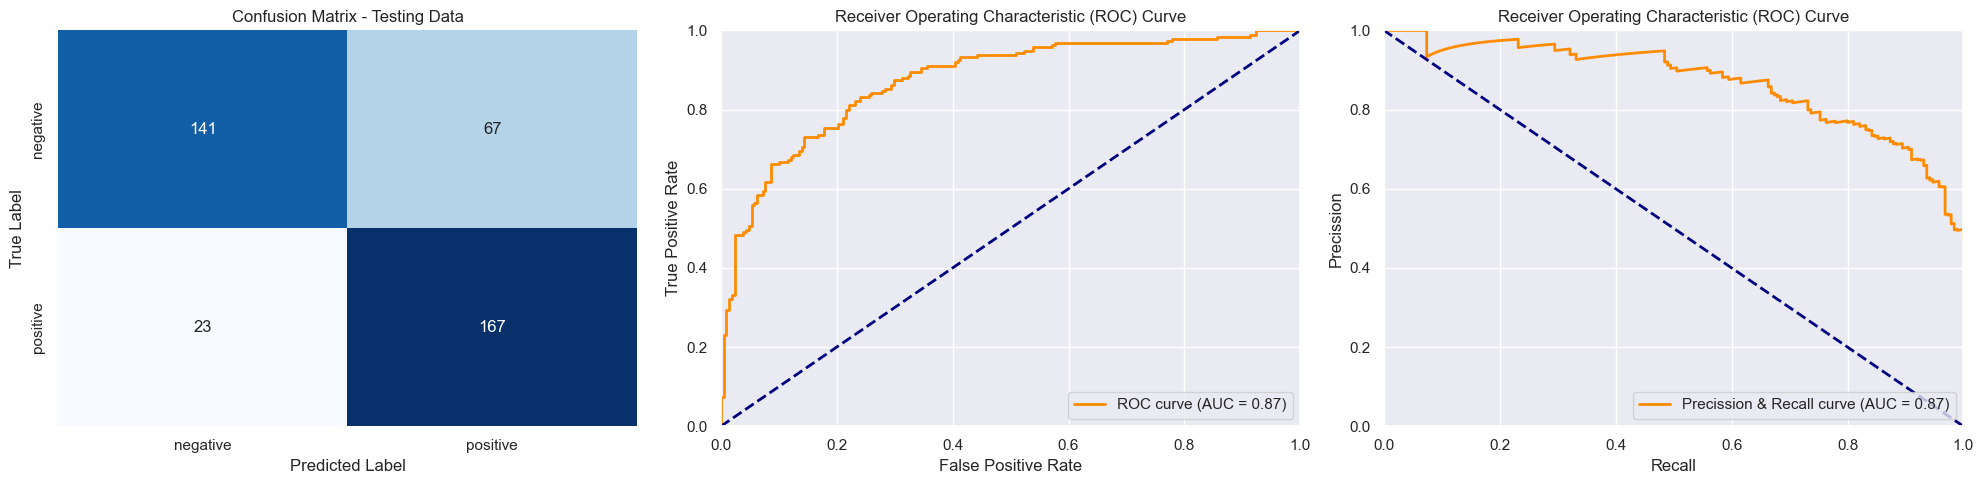

In [102]:
accuracy = accuracy_score(testing_data_labels, predictions(model_bilstm, X_testing, 0.28))
print(f"--> Model Testing Accuracy: {accuracy}")
class_report = classification_report(testing_data_labels, predictions(model_bilstm, X_testing, 0.28), target_names=['negative', 'positive'])
print(f"--> Model Classification Report: \n{class_report}")

print('--> Visual Analysis')
visual_analysis(model_bilstm, X_testing, testing_data_labels, 'Testing', 0.28)